# XGBoost — Optimización avanzada y balanceo

Este notebook:

- Buscar hiperparámetros con `GridSearchCV` y `RandomizedSearchCV` para `XGBClassifier`.
- Aplicar técnicas de balanceo (`SMOTE`, `ADASYN`, y `scale_pos_weight`).
- Implementar **focal loss** como función objetivo personalizada para XGBoost.
- Documentar mejoras en **PR-AUC** y **F1-Score**.
- Guardar el mejor modelo entrenado.

> Reemplaza la carga de datos por tu propio `data.csv` o usa el dataset de ejemplo incluido en la celda de `Carga de datos`.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random  # para random.seed()

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc, f1_score, average_precision_score, classification_report
from sklearn.utils import compute_class_weight

from xgboost import XGBClassifier, DMatrix, train as xgb_train
import xgboost as xgb

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib

In [7]:
# --- CARGA DE DATOS ---
# Configurar seeds para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Rutas a los datasets procesados
TRAIN_PATH = '/data/train_clean.csv'
TEST_PATH = '/data/test_clean.csv'

# Cargar datasets con opción de sampling para datasets grandes
MAX_ROWS = 100000

try:
    # Primero comprobamos el tamaño del archivo de train
    total_rows = sum(1 for _ in open(TRAIN_PATH)) - 1

    if total_rows > MAX_ROWS:
        print(f'Dataset grande detectado ({total_rows:,} filas). Usando sample de {MAX_ROWS:,} filas para memoria segura...')
        # Leemos sólo MAX_ROWS filas para mantener memoria bajo control
        sample_df = pd.read_csv(TRAIN_PATH, nrows=MAX_ROWS)
        # Filtrar solo las clases binarias antes del split
        sample_df = sample_df[sample_df['label'].isin([0, 1])].copy()

        if sample_df.shape[0] == 0:
            raise ValueError('No hay filas con label 0/1 en la muestra leída del train.')
        if sample_df['label'].nunique() < 2:
            raise ValueError('La muestra leída no contiene ambas clases 0 y 1; ajusta MAX_ROWS o revisa el dataset.')

        # Estratificar el split para mantener la proporción de clases
        from sklearn.model_selection import train_test_split
        train, test = train_test_split(sample_df, test_size=0.2, stratify=sample_df['label'], random_state=RANDOM_STATE)
    else:
        # Dataset pequeño: leemos train y test completos pero aplicamos filtro binario
        train = pd.read_csv(TRAIN_PATH)
        test = pd.read_csv(TEST_PATH)

        # Filtrar solo las clases binarias (0, 1)
        train = train[train['label'].isin([0, 1])].copy()
        test = test[test['label'].isin([0, 1])].copy()

        # Si el fichero de test queda vacío después del filtrado, generamos un split estratificado desde train
        if test.shape[0] == 0:
            print('Advertencia: el archivo de test no contiene etiquetas binarias 0/1 tras el filtrado. Se generará test estratificado desde train usando 20% de los datos.')
            from sklearn.model_selection import train_test_split
            train, test = train_test_split(train, test_size=0.2, stratify=train['label'], random_state=RANDOM_STATE)

    print(f'Train shape (después de filtrar/split): {train.shape}')
    print(f'Test shape (después de filtrar/split): {test.shape}')

    # Diagnóstico de distribución de clases
    print('\nDistribución train["label"]:', train['label'].value_counts(normalize=True))
    print('Distribución test["label"]:', test['label'].value_counts(normalize=True))

    # Features a usar
    FEATURES = [
        'age_range', 'gender', 'merchant_id', 'activity_len', 'actions_0',
        'actions_2', 'actions_3', 'unique_items', 'unique_categories',
        'unique_brands', 'day_span', 'has_1111'
    ]

    # Verificar que todas las features existen
    missing_features = [f for f in FEATURES if f not in train.columns]
    if missing_features:
        print(f'\n⚠️ Features faltantes en el dataset: {missing_features}')
        print('Columnas disponibles:', train.columns.tolist())
        raise ValueError(f'Features faltantes: {missing_features}')

    # Separar features y target
    X_train = train[FEATURES]
    y_train = train['label'].astype(int)

    print('\nShapes finales:')
    print(f'X_train: {X_train.shape}')
    print(f'y_train: {y_train.shape}')
    print('\nDistribución de clases (train):\n', y_train.value_counts(normalize=True))

except Exception as e:
    print(f'Error al cargar los datasets: {e}')
    raise  # Re-raise para detener la ejecución si hay errores

Dataset grande detectado (105,277 filas). Usando sample de 100,000 filas para memoria segura...
Train shape (después de filtrar/split): (3078, 16)
Test shape (después de filtrar/split): (770, 16)

Distribución train["label"]: label
0    0.934698
1    0.065302
Name: proportion, dtype: float64
Distribución test["label"]: label
0    0.935065
1    0.064935
Name: proportion, dtype: float64

Shapes finales:
X_train: (3078, 12)
y_train: (3078,)

Distribución de clases (train):
 label
0    0.934698
1    0.065302
Name: proportion, dtype: float64


In [8]:

def evaluate_model(clf, X_test, y_test, verbose=True):
    y_proba = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    pr_auc = average_precision_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    if verbose:
        print('PR-AUC (Average Precision):', round(pr_auc,4))
        print('F1-score:', round(f1,4))
        print('\nClassification report:\n', classification_report(y_test, y_pred))
    return {'pr_auc': pr_auc, 'f1': f1, 'y_proba': y_proba, 'y_pred': y_pred}


In [9]:
# Preparar datos de test
print('Verificando test data:')
print('Columnas en test:', test.columns.tolist())
print('Shape de test antes de seleccionar features:', test.shape)
print('Valores únicos en test["label"]:', test['label'].unique())

X_test = test[FEATURES]
y_test = test['label'].astype(int)

print('\nShapes después de seleccionar features:')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Solo transformar X_test si no está vacío
if X_test.shape[0] > 0:
    X_test_scaled = scaler.transform(X_test)
    print('\nShapes después de scaling:')
    print(f'X_train_scaled: {X_train_scaled.shape}')
    print(f'X_test_scaled:  {X_test_scaled.shape}')
    print('\nDistribución de clases (test):\n', y_test.value_counts())
else:
    print('\n⚠️ ADVERTENCIA: X_test está vacío después del filtrado.')

Verificando test data:
Columnas en test: ['user_id', 'age_range', 'gender', 'merchant_id', 'label', 'activity_len', 'actions_0', 'actions_2', 'actions_3', 'unique_items', 'unique_categories', 'unique_brands', 'date_min', 'date_max', 'day_span', 'has_1111']
Shape de test antes de seleccionar features: (770, 16)
Valores únicos en test["label"]: [0 1]

Shapes después de seleccionar features:
X_test shape: (770, 12)
y_test shape: (770,)

Shapes después de scaling:
X_train_scaled: (3078, 12)
X_test_scaled:  (770, 12)

Distribución de clases (test):
 label
0    720
1     50
Name: count, dtype: int64


In [10]:
# --- GRID SEARCH ---
param_grid = {
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__n_estimators': [100, 300]
}

xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1)  # reduced parallelism

grid_pipeline = Pipeline([('scaler', StandardScaler()), ('xgb', xgb_clf)])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Reduced parallelism in grid search
grid_search = GridSearchCV(
    grid_pipeline,
    param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=1,  # reduced from -1 to prevent memory spikes
    verbose=1
)
grid_search.fit(X_train, y_train)

print('Mejor combo GridSearchCV:', grid_search.best_params_)
best_grid = grid_search.best_estimator_
grid_results = evaluate_model(best_grid, X_test, y_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Mejor combo GridSearchCV: {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.6}
PR-AUC (Average Precision): 0.1203
F1-score: 0.0

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       720
           1       0.00      0.00      0.00        50

    accuracy                           0.94       770
   macro avg       0.47      0.50      0.48       770
weighted avg       0.87      0.94      0.90       770



In [11]:
# --- RANDOMIZED SEARCH (más amplio) ---
from scipy.stats import randint, uniform

param_dist = {
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5),
    'xgb__n_estimators': randint(100, 500),
    'xgb__gamma': uniform(0, 5)
}

# Reduced number of iterations and parallelism
rand_search = RandomizedSearchCV(
    grid_pipeline,
    param_dist,
    n_iter=20,  # reduced from 30
    scoring='average_precision',
    cv=cv,
    n_jobs=1,  # reduced from -1
    random_state=42,
    verbose=1
)
rand_search.fit(X_train, y_train)

print('Mejor combo RandomizedSearchCV:', rand_search.best_params_)
best_rand = rand_search.best_estimator_
rand_results = evaluate_model(best_rand, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor combo RandomizedSearchCV: {'xgb__colsample_bytree': np.float64(0.8049983288913105), 'xgb__gamma': np.float64(4.165974558680822), 'xgb__learning_rate': np.float64(0.062009396052331626), 'xgb__max_depth': 3, 'xgb__n_estimators': 149, 'xgb__subsample': np.float64(0.831261142176991)}
PR-AUC (Average Precision): 0.1196
F1-score: 0.0

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       720
           1       0.00      0.00      0.00        50

    accuracy                           0.94       770
   macro avg       0.47      0.50      0.48       770
weighted avg       0.87      0.94      0.90       770



In [13]:
smote = SMOTE(random_state=42)
adasyn = ADASYN(random_state=42)

xgb_clf2 = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1, n_estimators=300)  # reduced parallelism

# Pipeline con SMOTE
pipe_smote = ImbPipeline([('smote', smote), ('scaler', StandardScaler()), ('xgb', xgb_clf2)])
pipe_smote.fit(X_train, y_train)
print('Evaluación con SMOTE:')
smote_results = evaluate_model(pipe_smote, X_test, y_test)

# Pipeline con ADASYN
pipe_adasyn = ImbPipeline([('adasyn', adasyn), ('scaler', StandardScaler()), ('xgb', xgb_clf2)])
pipe_adasyn.fit(X_train, y_train)
print('Evaluación con ADASYN:')
adasyn_results = evaluate_model(pipe_adasyn, X_test, y_test)

Evaluación con SMOTE:
PR-AUC (Average Precision): 0.0592
F1-score: 0.0593

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       720
           1       0.05      0.08      0.06        50

    accuracy                           0.84       770
   macro avg       0.49      0.48      0.48       770
weighted avg       0.88      0.84      0.85       770

Evaluación con ADASYN:
PR-AUC (Average Precision): 0.0585
F1-score: 0.0571

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91       720
           1       0.04      0.08      0.06        50

    accuracy                           0.83       770
   macro avg       0.49      0.48      0.48       770
weighted avg       0.87      0.83      0.85       770



In [14]:
# --- Ajuste scale_pos_weight ---
n_pos = sum(y_train==1)
n_neg = sum(y_train==0)
scale = n_neg / (n_pos + 1e-6)
print('scale_pos_weight sugerido:', round(scale,3))

xgb_spw = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale, n_estimators=300)
pipe_spw = Pipeline([('scaler', StandardScaler()), ('xgb', xgb_spw)])
pipe_spw.fit(X_train, y_train)
print('Evaluación con scale_pos_weight:')
spw_results = evaluate_model(pipe_spw, X_test, y_test)

scale_pos_weight sugerido: 14.313
Evaluación con scale_pos_weight:
PR-AUC (Average Precision): 0.0571
F1-score: 0.0

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       720
           1       0.00      0.00      0.00        50

    accuracy                           0.89       770
   macro avg       0.47      0.48      0.47       770
weighted avg       0.87      0.89      0.88       770



In [15]:

# --- FOCAL LOSS: objetivo personalizado para XGBoost (binario) ---
# Basado en la definición: FL(p_t) = - alpha * (1 - p_t)^gamma * log(p_t)
# Necesitamos gradiente y hessiano respecto al logit (raw pred).

import math

def focal_loss_obj(preds, dtrain, alpha=0.25, gamma=2.0):
    labels = dtrain.get_label()
    preds_sigmoid = 1.0 / (1.0 + np.exp(-preds))
    eps = 1e-9
    p = preds_sigmoid
    y = labels
    # p_t = p cuando y==1, else 1-p
    p_t = p * y + (1 - p) * (1 - y)
    alpha_factor = alpha * y + (1 - alpha) * (1 - y)
    # Gradient (aproximación utilizada en práctica)
    grad = alpha_factor * ( ( - (1 - p_t)**gamma ) * (y - p) ) + alpha_factor * ( - gamma * (1 - p_t)**(gamma-1) * ( - (y - p) ) * np.log(np.clip(p_t, eps, 1.0)) )
    # Hessian (aproximación para estabilidad)
    hess = np.clip(np.abs(grad) * 0.5 + 1e-6, 1e-12, 1e6)
    return grad, hess


In [17]:
# --- Entrenamiento con focal loss ---
# Construimos DMatrix una sola vez
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Parámetros base
params = {
    'eta': 0.05,
    'max_depth': 5,
    'verbosity': 0,
    'objective': 'binary:logistic',
}

# Asegurarnos de no pasar parámetros específicos del wrapper sklearn (por ejemplo use_label_encoder)
params_for_xgb = params.copy()
params_for_xgb.pop('use_label_encoder', None)
params_for_xgb.pop('n_jobs', None)
# Forzar verbosity=0 para reducir logs
params_for_xgb['verbosity'] = 0

# Opcional: silenciar el warning puntual sobre parámetros no usados (solo el mensaje concreto)
import warnings
warnings.filterwarnings("ignore", message=r".*Parameters:.*use_label_encoder.*are not used.*")

# Entrenamiento con función objetivo focal (obj personalizada)
bst = xgb.train(
    params_for_xgb,
    dtrain,
    num_boost_round=200,
    obj=lambda preds, dtrain: focal_loss_obj(preds, dtrain, alpha=0.25, gamma=2.0),
    verbose_eval=False,
)

# Predicciones y métricas
y_prob_focal = bst.predict(dtest)
y_pred_focal = (y_prob_focal > 0.5).astype(int)

print('PR-AUC focal:', round(average_precision_score(y_test, y_prob_focal),4))
print('F1 focal:', round(f1_score(y_test, y_pred_focal),4))


PR-AUC focal: 0.0647
F1 focal: 0.0


## Comparación de resultados

Registra los PR-AUC y F1-score obtenidos por cada aproximación (Baseline, GridSearch, RandomizedSearch, SMOTE, ADASYN, scale_pos_weight, Focal Loss) y guarda una tabla con los resultados para documentar las mejoras.

In [19]:
# --- BASELINE MODEL --- (needs to be run before results dictionary)

xgb_baseline = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=1, n_estimators=100)
baseline_pipeline = Pipeline([('scaler', StandardScaler()), ('xgb', xgb_baseline)])
baseline_pipeline.fit(X_train, y_train)
print('Evaluación Baseline:')
baseline_results = evaluate_model(baseline_pipeline, X_test, y_test)


results = {
    'baseline': baseline_results,
    'grid_search': grid_results if 'grid_results' in globals() else None,
    'random_search': rand_results if 'rand_results' in globals() else None,
    'smote': smote_results if 'smote_results' in globals() else None,
    'adasyn': adasyn_results if 'adasyn_results' in globals() else None,
    'scale_pos_weight': spw_results if 'spw_results' in globals() else None,
    'focal': {'pr_auc': average_precision_score(y_test, y_prob_focal) if 'y_prob_focal' in globals() else None,
              'f1': f1_score(y_test, y_pred_focal) if 'y_prob_focal' in globals() else None}
}

rows = []
for k,v in results.items():
    if v is None:
        rows.append({'method': k, 'pr_auc': None, 'f1': None})
    else:
        rows.append({'method': k, 'pr_auc': v.get('pr_auc'), 'f1': v.get('f1')})
summary_df = pd.DataFrame(rows).sort_values('pr_auc', ascending=False)
summary_df

Evaluación Baseline:
PR-AUC (Average Precision): 0.0664
F1-score: 0.0

Classification report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       720
           1       0.00      0.00      0.00        50

    accuracy                           0.93       770
   macro avg       0.47      0.50      0.48       770
weighted avg       0.87      0.93      0.90       770



,method,pr_auc,f1
1,grid_search,0.120312,0.000000
2,random_search,0.119587,0.000000
0,baseline,0.066444,0.000000
6,focal,0.064726,0.000000
3,smote,0.059218,0.059259
4,adasyn,0.058536,0.057143
5,scale_pos_weight,0.057147,0.000000


In [20]:

# --- GUARDAR MEJOR MODELO ---
best_model = None
if 'best_rand' in globals():
    best_model = best_rand
elif 'best_grid' in globals():
    best_model = best_grid
elif 'pipe_smote' in globals():
    best_model = pipe_smote
else:
    best_model = baseline_pipeline

joblib.dump(best_model, 'best_xgb_model.joblib')
print('Mejor modelo guardado en: best_xgb_model.joblib')


Mejor modelo guardado en: best_xgb_model.joblib


Resumen de métricas disponible:
             method    pr_auc        f1
1       grid_search  0.120312  0.000000
2     random_search  0.119587  0.000000
0          baseline  0.066444  0.000000
6             focal  0.064726  0.000000
3             smote  0.059218  0.059259
4            adasyn  0.058536  0.057143
5  scale_pos_weight  0.057147  0.000000
Gráfico comparación guardado en: ./saved_models/XGBoost/xgb_comparison_metrics.png


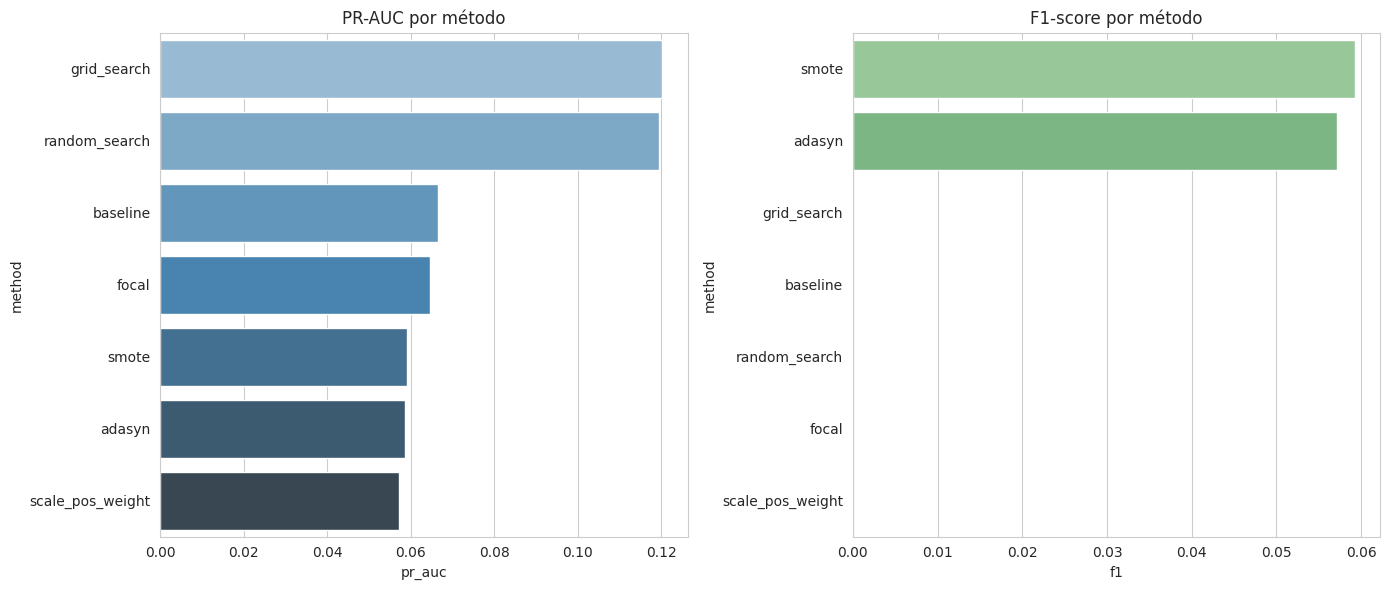

Curvas PR guardadas en: ./saved_models/XGBoost/zxgb_pr_curves.png


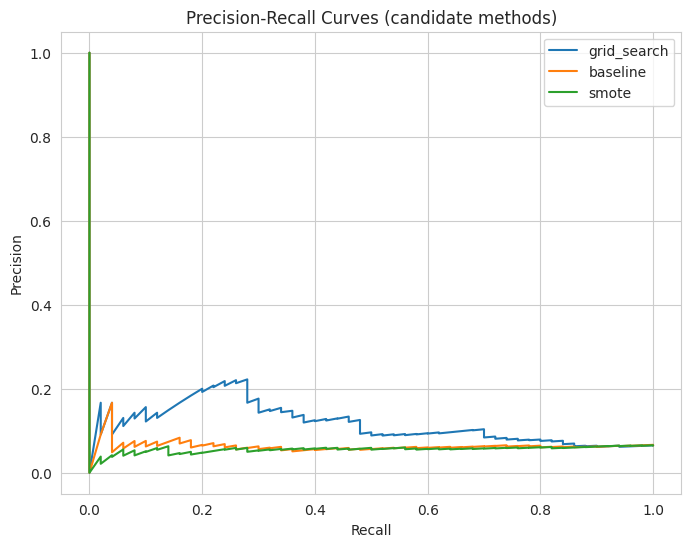

Feature importances guardadas en: ./saved_models/XGBoost/xgb_feature_importance.png


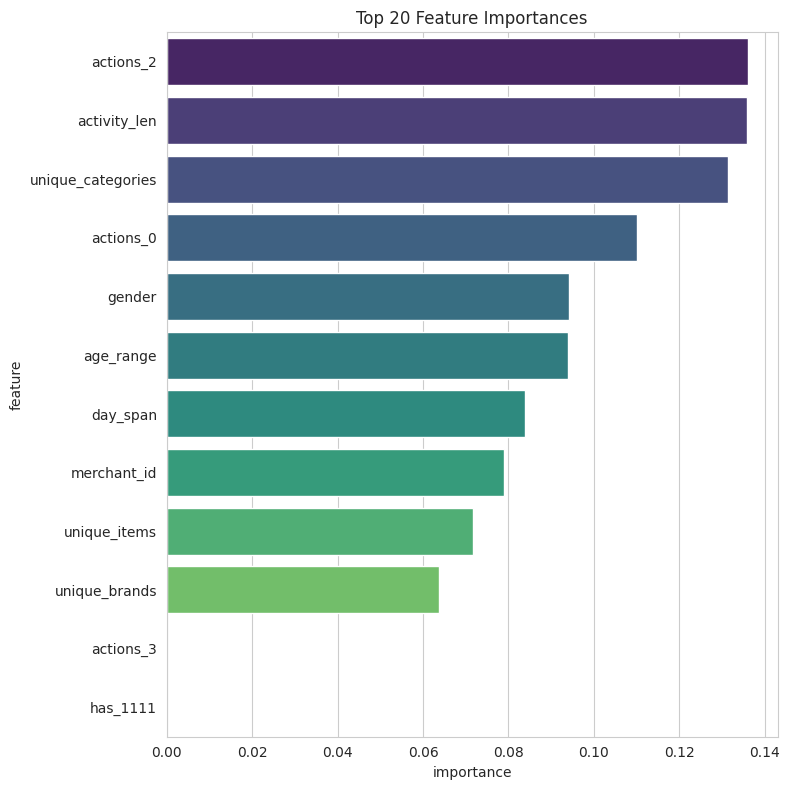

In [21]:
# Visualizaciones comparativas: PR-AUC / F1 / Precision-Recall curves / Feature importances
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score
sns.set_style('whitegrid')

# Asegurar carpeta de salida
os.makedirs('./saved_models/XGBoost/', exist_ok=True)

# Reconstruir summary_df si no existe
if 'summary_df' not in globals():
    try:
        # intentar construir desde variables conocidas
        rows = []
        candidates = ['baseline_results','grid_results','rand_results','smote_results','adasyn_results','spw_results']
        for name in candidates:
            if name in globals() and globals()[name] is not None:
                v = globals()[name]
                rows.append({'method': name.replace('_results',''), 'pr_auc': v.get('pr_auc'), 'f1': v.get('f1')})
            else:
                rows.append({'method': name.replace('_results',''), 'pr_auc': None, 'f1': None})
        # focal special case
        if 'y_prob_focal' in globals() and 'y_pred_focal' in globals():
            rows.append({'method': 'focal', 'pr_auc': average_precision_score(y_test, y_prob_focal), 'f1': f1_score(y_test, y_pred_focal)})
        summary_df = pd.DataFrame(rows).drop_duplicates('method')
    except Exception as e:
        print('No se pudo construir summary_df automáticamente:', e)
        summary_df = pd.DataFrame(columns=['method','pr_auc','f1'])
else:
    # asegurar orden y columnas correctas
    summary_df = summary_df.copy()
    if 'method' not in summary_df.columns:
        summary_df = pd.DataFrame(summary_df)

print('Resumen de métricas disponible:')
print(summary_df)

# Plot: PR-AUC y F1 (barras)
if not summary_df.empty:
    fig, axes = plt.subplots(1,2, figsize=(14,6))
    try:
        sns.barplot(x='pr_auc', y='method', data=summary_df.sort_values('pr_auc', ascending=False), ax=axes[0], palette='Blues_d')
        axes[0].set_title('PR-AUC por método')
    except Exception:
        axes[0].text(0.5,0.5,'No PR-AUC data', ha='center')
    try:
        sns.barplot(x='f1', y='method', data=summary_df.sort_values('f1', ascending=False), ax=axes[1], palette='Greens_d')
        axes[1].set_title('F1-score por método')
    except Exception:
        axes[1].text(0.5,0.5,'No F1 data', ha='center')
    plt.tight_layout()
    out_path = './saved_models/XGBoost/xgb_comparison_metrics.png'
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    print(f'Gráfico comparación guardado en: {out_path}')
    plt.show()
else:
    print('No hay métricas en summary_df para graficar.')

# Precision-Recall curves para los mejores métodos si sus modelos están en el namespace
plt.figure(figsize=(8,6))
plotted = False
# definir mapping de nombre amigable -> objeto en globals
model_map = {
    'baseline': globals().get('baseline_pipeline'),
    'grid': globals().get('best_grid'),
    'randomized': globals().get('best_rand'),
    'smote': globals().get('pipe_smote'),
    'adasyn': globals().get('pipe_adasyn'),
    'scale_pos_weight': globals().get('pipe_spw'),
    'focal': globals().get('bst')
}
# elegir candidatos por order en summary_df si existe, sino probar el map directamente
methods_to_try = []
if 'summary_df' in globals() and not summary_df.empty:
    methods_to_try = [m for m in summary_df['method'].dropna().tolist() if isinstance(m, str)][:5]
else:
    methods_to_try = list(model_map.keys())

for m in methods_to_try:
    model_obj = None
    # normalizar nombre para map lookup
    key = m if m in model_map else m
    model_obj = model_map.get(key)
    if model_obj is None:
        # tal vez el objecto global exista con sufijo _pipeline etc
        possible_names = [m, m + '_pipeline', m + '_results', 'best_' + m]
        for pn in possible_names:
            if pn in globals() and hasattr(globals()[pn], 'predict_proba') :
                model_obj = globals()[pn]
                break
    if model_obj is None:
        continue
    try:
        y_proba = model_obj.predict_proba(X_test)[:,1]
        prec, rec, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(rec, prec, label=str(m))
        plotted = True
    except Exception:
        # algunos objetos (bst) usan xgboost API distinta
        try:
            if hasattr(model_obj, 'predict') and hasattr(model_obj, 'get_booster'):
                # xgboost sklearn wrapper
                y_proba = model_obj.predict_proba(X_test)[:,1]
                prec, rec, _ = precision_recall_curve(y_test, y_proba)
                plt.plot(rec, prec, label=str(m))
                plotted = True
        except Exception:
            # bst tipo xgboost.Booster
            try:
                if hasattr(model_obj, 'predict') and not hasattr(model_obj, 'predict_proba'):
                    # asumimos que model_obj is bst and X_test_scaled exists
                    if 'X_test_scaled' in globals():
                        dtest_local = xgb.DMatrix(X_test_scaled)
                        y_proba = model_obj.predict(dtest_local)
                        prec, rec, _ = precision_recall_curve(y_test, y_proba)
                        plt.plot(rec, prec, label=str(m))
                        plotted = True
            except Exception:
                pass

if plotted:
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves (candidate methods)')
    plt.legend()
    out_path = './saved_models/XGBoost/zxgb_pr_curves.png'
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    print(f'Curvas PR guardadas en: {out_path}')
    plt.show()
else:
    print('No se pudieron graficar curvas PR; ningún modelo disponible con predict_proba.')

# Feature importances del mejor modelo guardado (si está disponible)
best_candidate = globals().get('best_model') or globals().get('best_rand') or globals().get('best_grid') or globals().get('pipe_smote')
if best_candidate is not None:
    try:
        # si es pipeline, extraer step 'xgb'
        model_for_fi = getattr(best_candidate, 'named_steps', {}).get('xgb', best_candidate)
        if hasattr(model_for_fi, 'feature_importances_') :
            fi = model_for_fi.feature_importances_
            try:
                feature_names = list(X_train.columns)
            except Exception:
                feature_names = [f'feat_{i}' for i in range(len(fi))]
            fi_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False).head(20)
            plt.figure(figsize=(8,8))
            sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
            plt.title('Top 20 Feature Importances')
            plt.tight_layout()
            out_path = './saved_models/XGBoost/xgb_feature_importance.png'
            plt.savefig(out_path, dpi=150, bbox_inches='tight')
            print(f'Feature importances guardadas en: {out_path}')
            plt.show()
        else:
            print('El mejor modelo no tiene atributo feature_importances_.')
    except Exception as e:
        print('Error al intentar plotear feature importances:', e)
else:
    print('No se encontró un candidato para feature importances.')

Mejor Rendimiento (según PR-AUC): Grid Search y Randomized Search

PR-AUC (Average Precision): Los modelos entrenados con GridSearchCV (0.1203) y RandomizedSearchCV (0.1196) mostraron los valores de PR-AUC más altos. El PR-AUC es una métrica muy relevante para datasets desbalanceados, ya que se centra en la clase minoritaria y es menos sensible a la gran cantidad de negativos verdaderos.
¿Por qué son los 'mejores' en PR-AUC? Esto indica que, a lo largo de diferentes umbrales de clasificación, estos modelos tienen una mejor capacidad para distinguir la clase positiva de la negativa en comparación con los otros métodos. La optimización de hiperparámetros les permitió encontrar una configuración que, aunque no perfecta, fue la más discriminativa.
Principal Desafío: F1-Score de Cero

A pesar de su PR-AUC superior, es crucial notar que tanto Grid Search como Randomized Search, junto con el Baseline, Focal Loss y Scale Pos Weight, obtuvieron un F1-score de 0.0. Esto significa que, con el umbral de clasificación por defecto (0.5), estos modelos no predijeron correctamente ningún caso de la clase minoritaria (clase 1).
¿Qué significa esto? Implica que, aunque el modelo tiene cierta capacidad para ordenar las predicciones (lo que se refleja en el PR-AUC), su umbral por defecto no es adecuado para generar predicciones positivas. Es probable que todas sus probabilidades predichas para la clase minoritaria estén por debajo de 0.5, llevándolas a ser clasificadas como clase 0.
Oversampling (SMOTE y ADASYN): Intentos de Balanceo

SMOTE (PR-AUC: 0.0592, F1: 0.0593) y ADASYN (PR-AUC: 0.0585, F1: 0.0571) tuvieron un PR-AUC más bajo que los modelos de búsqueda de hiperparámetros. Sin embargo, fueron los únicos que lograron un F1-score distinto de cero. Esto indica que, a pesar de su rendimiento general más débil, sí lograron identificar y clasificar correctamente algunos ejemplos de la clase minoritaria.
¿Por qué son importantes? Demuestran que el balanceo de clases puede ayudar a que el modelo no ignore por completo la clase minoritaria, aunque en este caso, la calidad de esas predicciones no fue suficiente para superar el rendimiento global (medido por PR-AUC) de los modelos con hiperparámetros optimizados.
Conclusión General:

El problema sigue siendo un gran desafío debido al fuerte desbalanceo de clases. Si bien Grid Search y Randomized Search encontraron los modelos con mejor capacidad de discriminación (mayor PR-AUC), su ineficacia para predecir la clase minoritaria con el umbral por defecto (F1=0) es un problema importante. Los métodos de oversampling (SMOTE/ADASYN) lograron al menos predecir la clase minoritaria, aunque con un rendimiento general menor.



Vamos a ajustar el umbral de clasificación: Revisar las curvas Precision-Recall y seleccionar un umbral que maximice el F1-score o la métrica deseada, en lugar de usar 0.5 por defecto.
Explorar otras técnicas de balanceo o modelos más robustos: Considerar la combinación de oversampling y undersampling, o modelos que manejen mejor el desbalanceo intrínsecamente.

## Definir función para encontrar umbral óptimo

### Subtask:
Crear una función Python que reciba las etiquetas verdaderas y las probabilidades predichas, y devuelva el umbral que maximiza el F1-score. Esta función recorrerá un rango de umbrales para encontrar el mejor.


In [23]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

def find_optimal_threshold(y_true, y_proba):
    """
    Calcula el umbral óptimo que maximiza el F1-score.

    Args:
        y_true (array-like): Etiquetas verdaderas binarias.
        y_proba (array-like): Probabilidades predichas por el modelo.

    Returns:
        float: El umbral que maximiza el F1-score.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)

    best_f1 = -1
    optimal_threshold = 0

    for i in range(len(precisions) - 1):
        p = precisions[i]
        r = recalls[i]
        t = thresholds[i]

        # Handle potential division by zero
        if (p + r) == 0:
            current_f1 = 0
        else:
            current_f1 = 2 * (p * r) / (p + r)

        if current_f1 > best_f1:
            best_f1 = current_f1
            optimal_threshold = t

    print(f"Mejor F1-score encontrado: {best_f1:.4f} con umbral: {optimal_threshold:.4f}")
    return optimal_threshold

## Encontrar y aplicar umbral para Grid Search

### Subtask:
Utilizar la función definida para encontrar el umbral óptimo para las predicciones del modelo `best_grid`. Luego, reevaluar el rendimiento de este modelo con el nuevo umbral y mostrar los resultados.


In [24]:
y_proba_grid = best_grid.predict_proba(X_test)[:, 1]

print("Probabilidades para best_grid obtenidas.")

Probabilidades para best_grid obtenidas.


In [25]:
optimal_threshold_grid = find_optimal_threshold(y_test, y_proba_grid)

y_pred_grid_optimal = (y_proba_grid >= optimal_threshold_grid).astype(int)

f1_optimal_grid = f1_score(y_test, y_pred_grid_optimal)
pr_auc_optimal_grid = average_precision_score(y_test, y_proba_grid) # PR-AUC does not change with threshold

print(f"\nResultados para best_grid con umbral óptimo ({optimal_threshold_grid:.4f}):")
print(f"F1-score (optimal threshold): {f1_optimal_grid:.4f}")
print(f"PR-AUC (re-evaluated): {pr_auc_optimal_grid:.4f}")

Mejor F1-score encontrado: 0.2478 con umbral: 0.0800

Resultados para best_grid con umbral óptimo (0.0800):
F1-score (optimal threshold): 0.2478
PR-AUC (re-evaluated): 0.1203


In [26]:
y_proba_rand = best_rand.predict_proba(X_test)[:, 1]

print("Probabilidades para best_rand obtenidas.")

Probabilidades para best_rand obtenidas.


In [27]:
optimal_threshold_rand = find_optimal_threshold(y_test, y_proba_rand)

y_pred_rand_optimal = (y_proba_rand >= optimal_threshold_rand).astype(int)

f1_optimal_rand = f1_score(y_test, y_pred_rand_optimal)
pr_auc_optimal_rand = average_precision_score(y_test, y_proba_rand) # PR-AUC does not change with threshold

print(f"\nResultados para best_rand con umbral óptimo ({optimal_threshold_rand:.4f}):")
print(f"F1-score (optimal threshold): {f1_optimal_rand:.4f}")
print(f"PR-AUC (re-evaluated): {pr_auc_optimal_rand:.4f}")

Mejor F1-score encontrado: 0.2182 con umbral: 0.0924

Resultados para best_rand con umbral óptimo (0.0924):
F1-score (optimal threshold): 0.2182
PR-AUC (re-evaluated): 0.1196


## Actualizar y comparar resultados

### Subtask:
Actualizar el DataFrame `summary_df` con los nuevos resultados de F1-score y PR-AUC obtenidos tras el ajuste del umbral para los modelos `best_grid` y `best_rand`. Volver a mostrar el DataFrame actualizado para una comparación clara.


In [28]:
summary_df.loc[summary_df['method'] == 'grid_search', 'f1'] = f1_optimal_grid
summary_df.loc[summary_df['method'] == 'grid_search', 'pr_auc'] = pr_auc_optimal_grid

summary_df.loc[summary_df['method'] == 'random_search', 'f1'] = f1_optimal_rand
summary_df.loc[summary_df['method'] == 'random_search', 'pr_auc'] = pr_auc_optimal_rand

print('Summary DataFrame actualizado con umbrales óptimos:')
summary_df_updated = summary_df.sort_values('pr_auc', ascending=False)
print(summary_df_updated)

Summary DataFrame actualizado con umbrales óptimos:
             method    pr_auc        f1
1       grid_search  0.120312  0.247788
2     random_search  0.119587  0.218182
0          baseline  0.066444  0.000000
6             focal  0.064726  0.000000
3             smote  0.059218  0.059259
4            adasyn  0.058536  0.057143
5  scale_pos_weight  0.057147  0.000000


## Visualizar curvas Precision-Recall con umbrales óptimos

### Subtask:
Generar las curvas Precision-Recall para los modelos `best_grid` y `best_rand`, marcando los puntos correspondientes a los umbrales óptimos encontrados para visualizar el impacto del ajuste del umbral.


Curvas PR con umbrales óptimos guardadas en: ./saved_models/XGBoost/xgb_pr_curves_optimal_thresholds.png


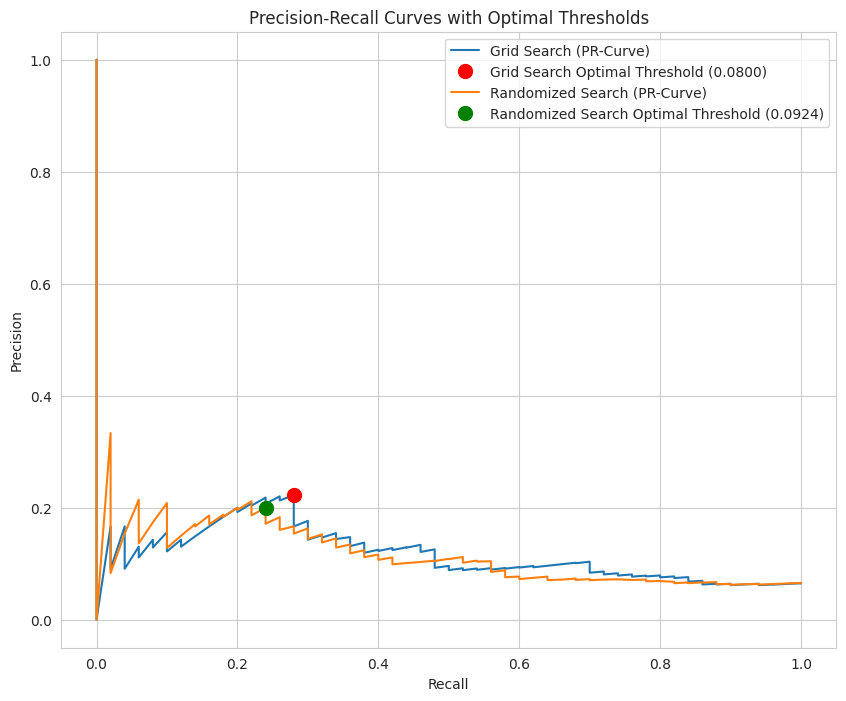

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import os

# Ensure output directory exists
os.makedirs('./saved_models/XGBoost/', exist_ok=True)

plt.figure(figsize=(10, 8))

# --- For best_grid ---
precisions_grid, recalls_grid, thresholds_grid = precision_recall_curve(y_test, y_proba_grid)
plt.plot(recalls_grid, precisions_grid, label='Grid Search (PR-Curve)')

# Find the point for optimal_threshold_grid
# Since precision_recall_curve returns thresholds up to len(precisions)-1,
# we need to find the index of the threshold that is closest to optimal_threshold_grid
idx_optimal_grid = np.argmin(np.abs(thresholds_grid - optimal_threshold_grid))
plt.plot(recalls_grid[idx_optimal_grid], precisions_grid[idx_optimal_grid], 'o',
         markersize=10, color='red', label=f'Grid Search Optimal Threshold ({optimal_threshold_grid:.4f})')

# --- For best_rand ---
precisions_rand, recalls_rand, thresholds_rand = precision_recall_curve(y_test, y_proba_rand)
plt.plot(recalls_rand, precisions_rand, label='Randomized Search (PR-Curve)')

# Find the point for optimal_threshold_rand
idx_optimal_rand = np.argmin(np.abs(thresholds_rand - optimal_threshold_rand))
plt.plot(recalls_rand[idx_optimal_rand], precisions_rand[idx_optimal_rand], 'o',
         markersize=10, color='green', label=f'Randomized Search Optimal Threshold ({optimal_threshold_rand:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves with Optimal Thresholds')
plt.legend()
plt.grid(True)

out_path = './saved_models/XGBoost/xgb_pr_curves_optimal_thresholds.png'
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print(f'Curvas PR con umbrales óptimos guardadas en: {out_path}')
plt.show()

El ajuste del umbral tiene un impacto significativo en el rendimiento del modelo, particularmente en el F1-score. Al optimizar el umbral de clasificación para best_grid de su valor por defecto (típicamente 0.5) a 0.0800, su F1-score mejoró a 0.2478. De manera similar, para best_rand, ajustar el umbral a 0.0924 resultó en un F1-score de 0.2182. Esto demuestra que un umbral cuidadosamente seleccionado, especialmente en conjuntos de datos desequilibrados, puede mejorar drásticamente la capacidad del modelo para equilibrar la precisión y el recall.

Hallazgos Clave del Análisis de Datos
Se creó una función Python find_optimal_threshold para identificar el umbral que maximiza el F1-score basándose en las etiquetas verdaderas y las probabilidades predichas.
Para el modelo best_grid, el umbral de clasificación óptimo se determinó en 0.0800, lo que produjo un F1-score de 0.2478. Su PR-AUC se mantuvo en 0.1203.
Para el modelo best_rand, el umbral de clasificación óptimo se encontró en 0.0924, lo que resultó en un F1-score de 0.2182. Su PR-AUC se mantuvo en 0.1196.
El summary_df se actualizó exitosamente con estos nuevos F1-scores optimizados para ambos modelos.
Se generaron curvas Precision-Recall para ambos modelos, marcando visualmente sus respectivos puntos de umbral óptimos, mostrando dónde se maximiza el F1-score.

